# <a id="table-of-contents"></a>Table of Contents

1. [Portfolio_marginal_attributes](#portfolio_marginal_attributes)
2. [Portfolio_attributes](#portfolio_attributes)

---

In [1]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt


from plotly.subplots import make_subplots
from scipy.stats import trim_mean
from scipy.stats import kurtosis, skew

In [2]:
# MANUAL INPUTS

#List portfolio securities here:
portfolio_with_candidate = ["SPY_history.csv", "XLU_history.csv", "XLF_history.csv"]
portfolio_without_candidate= ["XLF_history.csv","SPY_history.csv"]
candidate = ["XLU_history.csv"]

# Define weights_with_candidate (make sure the keys match the column names):
weights_with_candidate = {
    'Return_SPY': 0.3,  # 50% weight to SPY
    'Return_XLU': 0.5,  # 30% weight to XLU
    'Return_XLF': 0.2   # 20% weight to XLF
}

observations_to_keep= 1500

In [3]:
def process_portfolio_data(portfolio_with_candidate):
    # Define the Data folder path
    data_folder = os.path.join(os.path.expanduser("~/Desktop/Trading"), "Data")
    
    # Initialize an empty list to store the DataFrames
    data_frames = []
    
    # Iterate over the list of security files
    for file_name in portfolio_with_candidate:
        # Construct the full file path
        file_path = os.path.join(data_folder, file_name)
        
        # Read the CSV file into a DataFrame
        data = pd.read_csv(file_path)
        
        # Convert 'Date' column to datetime format
        data['Date'] = pd.to_datetime(data['Date'])
        
        # Extract security name from file name (e.g., "SPY" from "SPY_history.csv")
        security_name = file_name.split('_')[0]
        
        # Rename columns to include security name
        data = data.add_suffix(f'_{security_name}')
        
        # Calculate day-over-day price change based on 'Close' column
        data[f'Return_{security_name}'] = data[f'Close/Last_{security_name}'].pct_change()
        
        # Append the DataFrame to the list
        data_frames.append(data)
    
    # Combine all CSV side by side
    combined_data = pd.concat(data_frames, axis=1)
    
    # Calculate the portfolio's daily return (average of all securities' daily returns)
    return_columns = [col for col in combined_data.columns if col.startswith("Return_")]
    combined_data["portfolio_daily_return"] = combined_data[return_columns].mean(axis=1)
    
    # Add Original_Index column to capture current index
    combined_data['Original_Index'] = combined_data.index
    
    return combined_data

In [4]:
# Process the data for different portfolios
data_with_candidate_combined = process_portfolio_data(portfolio_with_candidate)
data_without_candidate_combined = process_portfolio_data(portfolio_without_candidate)
data_candidate_combined = process_portfolio_data(candidate)

In [5]:
# Add function to sort DataFrame by Original_Index
def sort_by_original_index(data):
    return data.sort_values(by='Original_Index', ascending=False)

# Sort the DataFrames by Original_Index
portfolio_with_candidate = sort_by_original_index(data_with_candidate_combined)
portfolio_without_candidate = sort_by_original_index(data_without_candidate_combined)
candidate = sort_by_original_index(data_candidate_combined)

In [6]:
#  Alternative approach (modifying in place if desired, be cautious with this!):
def drop_indices_in_place(df):
  if len(df) > observations_to_keep:
      df.drop(index=df.index[:observations_to_keep], axis=0, inplace=True)  # Efficient for large DataFrames
      df.reset_index(drop=True, inplace=True) # Reset index after dropping
# No return needed as it modifies in place


# Example of in-place usage:
drop_indices_in_place(portfolio_with_candidate)
drop_indices_in_place(portfolio_without_candidate)
drop_indices_in_place(candidate)

## Portfolio_marginal_attributes <a id="portfolio_marginal_attributes"></a>

[Back to Table of Contents](#table-of-contents)

In [7]:
def calculate_weighted_metrics(df, weights):
    
    # Filter weights to only include columns that exist in the subset of securities (df.columns)
    valid_weights = {col: weight for col, weight in weights.items() if col in df.columns}
    
    # Normalize the weights to ensure the total weight equals 1
    total_weight = sum(valid_weights.values())
    normalized_weights = {col: weight / total_weight for col, weight in valid_weights.items()}

    # Initialize weighted skewness and kurtosis
    weighted_skew = 0
    weighted_kurtosis = 0

    # Loop through each valid column and calculate skewness and kurtosis
    for column_name, weight in normalized_weights.items():
        data = df[column_name].dropna()  # Drop NaNs from the column
        
        # Calculate individual skewness and kurtosis
        skewness = skew(data)
        kurt = kurtosis(data)

        # Apply weights to the metrics
        weighted_skew += skewness * weight
        weighted_kurtosis += kurt * weight

    return {
        'portfolio_weighted_skew': weighted_skew,
        'portfolio_weighted_kurtosis': weighted_kurtosis,
        'normalized_weights': normalized_weights  # Return updated weights for the subset
    }

In [18]:
print(calculate_weighted_metrics(data_with_candidate_combined, weights_with_candidate)) 
print(calculate_weighted_metrics(data_without_candidate_combined, weights_with_candidate)) 
print(calculate_weighted_metrics(data_candidate_combined, weights_with_candidate))

{'portfolio_weighted_skew': 0.8085280874340329, 'portfolio_weighted_kurtosis': 15.627860449017438, 'normalized_weights': {'Return_SPY': 0.3, 'Return_XLU': 0.5, 'Return_XLF': 0.2}}
{'portfolio_weighted_skew': 1.0093302801348536, 'portfolio_weighted_kurtosis': 15.530671908266383, 'normalized_weights': {'Return_SPY': 0.6, 'Return_XLF': 0.4}}
{'portfolio_weighted_skew': 0.6077258947332123, 'portfolio_weighted_kurtosis': 15.725048989768496, 'normalized_weights': {'Return_XLU': 1.0}}


In [23]:
def plot_kurtosis_skew_overlay(df1, df2, df3, column_name, labels):
    """
    Calculates kurtosis and skew for three DataFrames and overlays their histograms.

    Args:
        df1, df2, df3 (pd.DataFrame): The three DataFrames to compare.
        column_name (str): The column name to analyze and plot.
        labels (list): A list of three labels corresponding to the DataFrames.

    Returns:
        dict: A dictionary with kurtosis and skew for all three DataFrames.
    """
    results = {}

    # Calculate kurtosis and skew for all three DataFrames
    try:
        for df, label in zip([df1, df2, df3], labels):
            if column_name in df.columns:
                data = df[column_name].dropna()
                if len(data) < 2:
                    print(f"Warning: Not enough data in '{column_name}' for {label}. Skipping.")
                    continue

                # Calculate kurtosis and skew
                k = kurtosis(data)
                s = skew(data)

                results[label] = {'kurtosis': k, 'skew': s}
            else:
                print(f"Warning: '{column_name}' not found in {label}. Skipping.")

        # Plot overlapping histograms
        plt.figure(figsize=(10, 6))
        for df, label, color in zip([df1, df2, df3], labels, ['skyblue', 'lightcoral', 'lightgreen']):
            if column_name in df.columns:
                data = df[column_name].dropna()
                plt.hist(data, bins=40, alpha=0.5, label=f"{label}", color=color, edgecolor='black', linewidth=1.0)

        plt.title(f'Distribution of {column_name}')
        plt.xlabel(column_name)
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"An unexpected error occurred: {e}")
    
    return results

In [24]:
plot_kurtosis_skew_overlay(data_with_candidate_combined,data_without_candidate_combined,data_candidate_combined,column_name, labels)

NameError: name 'column_name' is not defined

In [25]:
# Analyze portfolio_daily_return across all three scenarios
column_to_analyze = 'portfolio_daily_return'

# Define labels for the three DataFrames
labels = ["With Candidate", "Without Candidate", "Candidate Only"]

# Call the function
results = plot_kurtosis_skew_overlay(
    portfolio_with_candidate, 
    portfolio_without_candidate, 
    candidate, 
    column_to_analyze,
    labels
)

# Print the results
for label, stats in results.items():
    print(f"{label}:")
    print(f"  Kurtosis = {stats['kurtosis']:.4f}, Skew = {stats['skew']:.4f}")


An unexpected error occurred: name 'plt' is not defined
With Candidate:
  Kurtosis = 1.8196, Skew = 0.2173
Without Candidate:
  Kurtosis = 1.7199, Skew = 0.2044
Candidate Only:
  Kurtosis = 1.2130, Skew = 0.2781


In [11]:
def trimmed_std_dev(data, trim_percent=0.02):
    """
    Calculate the trimmed standard deviation for a portfolio's average daily return.

    Parameters:
    - data (pd.DataFrame): DataFrame containing daily returns of all securities
    - trim_percent (float): Percentage of observations to trim from each end (default 10%)

    Returns:
    - float: Trimmed standard deviation of the portfolio
    """
    # Select only return columns (avoid including other numerical data)
    return_columns = [col for col in data.columns if col.startswith("Return_")]
    if not return_columns:
        raise ValueError("No return columns found in the dataset!")

    # Compute the portfolio's daily return (average of all securities' daily returns)
    data["portfolio_daily_return"] = data[return_columns].mean(axis=1)

    # Extract the portfolio daily returns as a series
    portfolio_returns = data["portfolio_daily_return"].dropna().values

    # Trim the extreme observations
    trim_count = int(len(portfolio_returns) * trim_percent)
    sorted_returns = np.sort(portfolio_returns)
    trimmed_returns = sorted_returns[trim_count:-trim_count]  # Trim bottom & top values

    # Compute and return standard deviation of the trimmed dataset
    return np.std(trimmed_returns, ddof=1)


In [12]:
# Compute trimmed standard deviations
trimmed_std_portfolio_without_candidate = trimmed_std_dev(portfolio_without_candidate, trim_percent=0.02)
trimmed_std_portfolio_with_candidate = trimmed_std_dev(portfolio_with_candidate, trim_percent=0.02)
trimmed_std_candidate = trimmed_std_dev(candidate, trim_percent=0.02)

# Print results
print("Trimmed Std Dev (Portfolio without Candidate):", trimmed_std_portfolio_without_candidate)
print("Trimmed Std Dev (Candidate Security):", trimmed_std_candidate)
print("Trimmed Std Dev (Portfolio with Candidate):", trimmed_std_portfolio_with_candidate)

Trimmed Std Dev (Portfolio without Candidate): 0.008740266808113857
Trimmed Std Dev (Candidate Security): 0.009446978772188083
Trimmed Std Dev (Portfolio with Candidate): 0.007784708045209008


In [13]:
def gini_mean_difference(data, column):
    """
    Calculate the Gini mean difference for a specified column in a DataFrame.
    
    Args:
        data (pd.DataFrame): The DataFrame containing the data.
        column (str): The column name for which to calculate the Gini mean difference.
        
    Returns:
        float: The Gini mean difference.
    """
    # Extract the specified column values
    values = data[column].dropna().values
    
    # Calculate the absolute differences between all pairs of elements
    diff_matrix = np.abs(np.subtract.outer(values, values))
    
    # Calculate the mean of the absolute differences
    gini_mean_diff = np.mean(diff_matrix)
    
    return gini_mean_diff


In [14]:
gini_portfolio_with_candidate = gini_mean_difference(portfolio_with_candidate, 'portfolio_daily_return')
gini_portfolio_without_candidate = gini_mean_difference(portfolio_without_candidate, 'portfolio_daily_return')
gini_candidate = gini_mean_difference(candidate, 'portfolio_daily_return')

print(f'Gini Mean Difference (without candidate): {gini_portfolio_without_candidate}')
print(f'Gini Mean Difference (candidate): {gini_candidate}')
print(f'Gini Mean Difference (with candidate): {gini_portfolio_with_candidate}')

Gini Mean Difference (without candidate): 0.011364237941021493
Gini Mean Difference (candidate): 0.012184563121654236
Gini Mean Difference (with candidate): 0.010105626515862097


In [15]:
def plot_clustered_bar_chart_with_labels(gini_values, trimmed_std_values, labels):
    """
    Plots a clustered bar chart with value labels for Gini mean difference
    and trimmed standard deviation for three portfolios.

    Args:
        gini_values (list): A list of Gini mean differences for the portfolios.
        trimmed_std_values (list): A list of trimmed standard deviations for the portfolios.
        labels (list): A list of labels for the portfolios.
    """
    # Number of portfolios
    n_portfolios = len(labels)

    # Bar positions
    x = np.arange(n_portfolios)  # X-axis positions for the groups
    bar_width = 0.35  # Width of each bar

    # Plot bars
    plt.figure(figsize=(10, 6))
    gini_bars = plt.bar(x - bar_width / 2, gini_values, width=bar_width, label='Gini Mean Difference', color='skyblue')
    std_bars = plt.bar(x + bar_width / 2, trimmed_std_values, width=bar_width, label='Trimmed Std Dev', color='lightcoral')

    # Add labels and title
    plt.title('Comparison of Portfolio Statistics')
    plt.xlabel('Portfolios')
    plt.ylabel('Values')
    plt.xticks(x, labels)  # Set portfolio labels for x-axis ticks
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.5)

    # Add value labels to the bars
    for bar in gini_bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.4f}', ha='center', va='bottom', fontsize=10)

    for bar in std_bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.4f}', ha='center', va='bottom', fontsize=10)

    # Display the plot
    plt.tight_layout()
    plt.show()

# Define the calculated values
gini_values = [gini_portfolio_with_candidate, gini_portfolio_without_candidate, gini_candidate]
trimmed_std_values = [trimmed_std_portfolio_with_candidate, trimmed_std_portfolio_without_candidate, trimmed_std_candidate]
labels = ["With Candidate", "Without Candidate", "Candidate Only"]

# Call the function to plot the bar chart
plot_clustered_bar_chart_with_labels(gini_values, trimmed_std_values, labels)


NameError: name 'plt' is not defined

## Portfolio_attributes <a id="portfolio_attributes"></a>

[Back to Table of Contents](#table-of-contents)

In [19]:
# Select only the "Close/Last_" columns
close_columns = [col for col in portfolio_with_candidate.columns if col.startswith('Close/Last_')]

# Calculate daily percentage returns
returns = portfolio_with_candidate[close_columns].pct_change()

# Drop NaN values (from the first row caused by pct_change)
returns = returns.dropna()

# 1. Correlation Matrix
correlation_matrix = returns.corr()

# 2. Covariance Matrix
covariance_matrix = returns.cov()

# 3. Beta Matrix - Adjust to have the same shape as correlation and covariance matrices
benchmark = close_columns[0]
betas = {}

# Initialize beta_matrix with NaN values to match the size of the correlation and covariance matrices
beta_matrix = pd.DataFrame(np.nan, index=close_columns, columns=close_columns)

for col in close_columns:
    for row in close_columns:
        if col == row:
            beta_matrix.loc[row, col] = 1
        else:
            beta = covariance_matrix.loc[col, benchmark] / covariance_matrix.loc[benchmark, benchmark] 
            beta_matrix.loc[col, benchmark] = beta

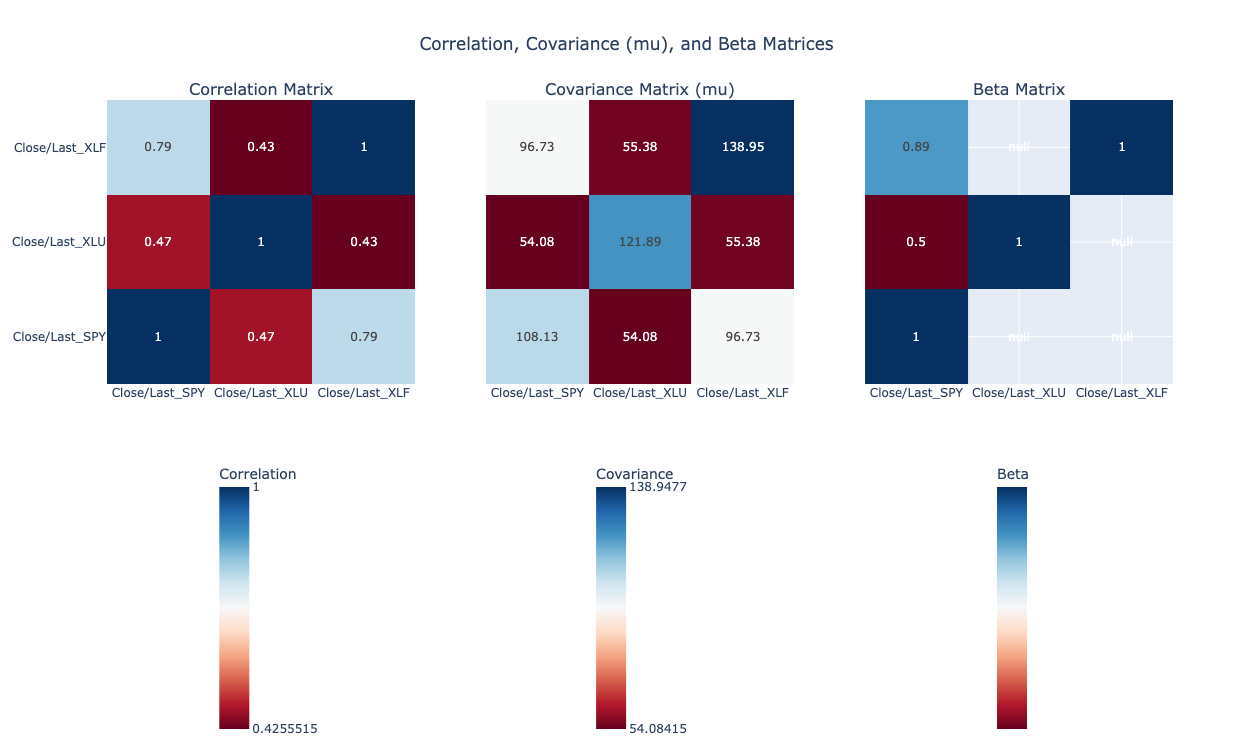

In [20]:
# Define a conversion factor for covariance (e.g., multiplying by 1e6 for 'mu' units)
covariance_conversion_factor = 1e6  # Adjust this based on what "mu" represents

# Apply conversion factor to covariance matrix
covariance_matrix_mu = covariance_matrix * covariance_conversion_factor

# Store matrices in a dictionary for dynamic plotting
matrices = {
    "Correlation Matrix": correlation_matrix,
    "Covariance Matrix (mu)": covariance_matrix_mu,  # Use converted covariance matrix
    "Beta Matrix": beta_matrix
}

num_matrices = len(matrices)  # Adjust based on how many matrices you have

# Create subplots dynamically
fig = make_subplots(
    rows=1, cols=num_matrices,  
    subplot_titles=list(matrices.keys()),  # Dynamically set titles
    column_widths=[1/num_matrices] * num_matrices,  
    shared_yaxes=True,
    shared_xaxes=True
)

# Adjust x positions for colorbars below each heatmap, adding some spacing
x_positions = np.linspace(0.15, 0.85, num_matrices)  # Spread them evenly from left to right with spacing

# Add each matrix as a heatmap dynamically
for i, (title, matrix) in enumerate(matrices.items(), start=1):
    fig.add_trace(
        go.Heatmap(
            z=matrix.values,
            x=matrix.columns,
            y=matrix.columns,
            colorscale="RdBu",
            colorbar=dict(
                title=title.split()[0],  # Use first word of title (Correlation, Covariance, Beta)
                tickvals=[matrix.values.min(), 0, matrix.values.max()],
                yanchor="top",
                y=-0.25,  # Move colorbar slightly below the heatmap
                x=x_positions[i - 1],  # Align it under each respective heatmap with spacing
                xanchor="center",
                orientation="v"  # Make the colorbar vertical
            ),
            text=matrix.values.round(2),
            texttemplate="%{text}",
            showscale=True,
            hoverinfo="skip"
        ),
        row=1, col=i
    )

# Update layout
fig.update_layout(
    title="Correlation, Covariance (mu), and Beta Matrices",
    height=750,  # Increased height to accommodate vertical legends
    showlegend=False,
    title_x=0.5
)

# Show the interactive heatmap
fig.show()
